In [1]:
import pandas as pd
import folium
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gpd
import libpysal
from shapely.geometry import Point, Polygon
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
from contextily import add_basemap
import networkx as nx
import numpy as np
import logging
import requests_cache
import requests
import json

In [2]:
df = pd.read_csv(r"C:\Users\marco\Downloads\Electric_Vehicle_Charging_Stations_in_New_York.csv")

In [3]:
df['Year'] = df['Open Date'].str[6:]
df = df.fillna(value=0)
df = df.drop(['Fuel Type Code', 'Intersection Directions','Station Phone','Status Code','Owner Type Code',
         'Federal Agency ID','Federal Agency Name','Cards Accepted',
         'EV Network Web','ZIP','Groups With Access Code','Expected Date','Access Days Time',
         'Geocode Status','Updated At','Plus4','Date Last Confirmed',"EV Other Info","Open Date"], axis=1)

In [4]:
df.tail(50)

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Year
3090,EAGLE AUTO MALL CT4000,1320 Old Country Rd,Riverhead,NY,0.0,2.0,0.0,ChargePoint Network,40.928873,-72.684689,199375,J1772,2021
3091,"Sam's Club 6428 (Medford, NY)",2950 Horseblock Rd,Medford,NY,0.0,0.0,4.0,Electrify America,40.826200,-72.990420,170300,CHADEMO J1772COMBO,2020
3092,Cloudsplitter Outfitters LLC,5302 Rt 28N,Newcomb,NY,0.0,2.0,0.0,EV Connect,43.966471,-74.130182,154919,J1772,2019
3093,Courier's Lot,2157 Main St Buffalo,Buffalo,NY,0.0,2.0,0.0,EV Connect,42.928965,-78.847627,202629,J1772,2021
3094,National Grid - Syracuse Office Center,300 Erie Blvd W,Syracuse,NY,0.0,8.0,0.0,ChargePoint Network,43.051581,-76.157208,123603,J1772,2019
3095,Champion Parking 90 LLC - Tesla,60 E 90th St,New York,NY,0.0,3.0,0.0,Tesla,40.783085,-73.956304,115167,J1772 TESLA,2017
3096,Aqueduct Parking Lot,110 Main Street,irvington,NY,0.0,2.0,0.0,EV Connect,41.038926,-73.867014,168429,J1772,2020
3097,Winwood Inn - Windham Mountain Resort - Tesla,5220 State Rte 23,Windham,NY,0.0,2.0,0.0,Tesla,42.310435,-74.241272,115250,TESLA,2017
3098,Ravenswood Pub,1021 Rt 146 Clifton Park,Clifton Park,NY,0.0,4.0,0.0,LIVINGSTON,42.870910,-73.817990,223130,J1772,2021
3099,854ELLICOTT 134 HIGH ST 5,134 High St,Buffalo,NY,0.0,2.0,0.0,ChargePoint Network,42.900856,-78.863837,181843,J1772,2021


In [5]:
città_rilevanti = ['New York',"Bronx","Brooklyn","Queens","Staten Island",
         "Manhattan","Borough Park","Washington Heights","New York City",
        "Astoria","Jamaica","JAMAICA","Jackson Heights",]
esclusione = ["Geneva on the Lake Resort", "ABELENORTHSIDE STATION 1","Buy Low Flooring / Queen of Harts Pizza"]
Network = ["Tesla","LIVINGSTON","EV Connect"]

In [6]:
# occurrences = df['EV_Network'].value_counts()
# print(occurrences)

I 4 maggiori Network di ricarica appartengono a Tesla, Livingstone e EV Connect, e quelli che non sono compresi in nessun network specifico. Con questi 4 otteniamo circa il 42% della rete. 

Vengono eliminate le colonne che non presentano dati utili all'analisi o che presentano dei NaN in ogni osservazione.

In [7]:
df.index.names = ['Index']
df = df.fillna(value=0)
df.shape

(3140, 13)

Il dataset presenta 3140 osservazioni, solo relative allo stato di New York. 

In [8]:
df =df.reset_index(drop=True)

In [9]:
df

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Year
0,ShopRite Plaza,2333 Nott St E,Niskayuna,NY,0.0,2.0,0.0,Non-Networked,42.816614,-73.889657,50854,J1772,2021
1,GMC Copley Parking - Tesla,2000 Broadway,New York,NY,0.0,3.0,0.0,Tesla,40.775496,-73.981552,115044,TESLA,2017
2,WHITE PLAINS EVSE1,1 Maple Ave,White Plains,NY,0.0,2.0,0.0,ChargePoint Network,41.028410,-73.759380,197206,J1772,2021
3,3500 Dekalb Ave,3500 Dekalb Ave,Bronx,NY,0.0,2.0,0.0,FLO,40.882337,-73.880265,201636,J1772,2021
4,134 N 4th St,134 N 4th St,Brooklyn,NY,0.0,4.0,0.0,FLO,40.716441,-73.960043,202931,J1772,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,SPOT cowork Rochester - Tesla,21 Goodway Dr,Rochester,NY,0.0,4.0,0.0,Tesla,43.091974,-77.580604,154441,TESLA,2020
3136,Veterans Memorial Park,185 Main St,Mount Morris,NY,0.0,4.0,0.0,EV Connect,42.718388,-77.869315,168430,J1772,2020
3137,CHEEKTOWAGA ALEXANDER #4,275 Alexander Ave,Buffalo,NY,0.0,1.0,0.0,ChargePoint Network,42.913030,-78.791232,183769,J1772,2021
3138,286WAE 286 WAS AVE EXT,286 Washington Ave Ext,Albany,NY,0.0,2.0,0.0,ChargePoint Network,42.705350,-73.860690,152461,J1772,2020


In [10]:
# NYC_df["Next Latitude"],NYC_df["Next Longitude"] = "",""

In [11]:
# for i in range(0, (NYC_df.shape[0]-1)):
#          NYC_df["Next Latitude"][i] = NYC_df["Latitude"][i+1]
#          NYC_df["Next Longitude"][i] = NYC_df["Longitude"][i+1]

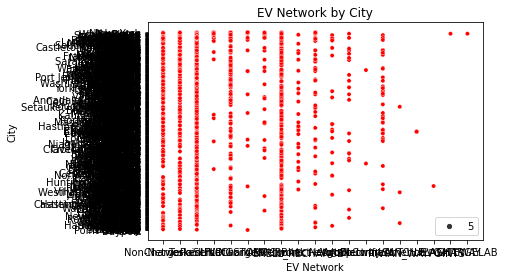

In [12]:
sns.scatterplot(x='EV_Network', y='City', data=df, size=5, color='red')
plt.title("EV Network by City")
plt.xlabel("EV Network")
plt.ylabel("City")
plt.show()

Plot della mappa

In [13]:
location = df[["Latitude", "Longitude", "Station Name","EV_Network","ID"]]

In [14]:
# Calculate the center of the map based on the mean of Latitude and Longitude values
mean_latitude = location['Latitude'].mean()
mean_longitude = location['Longitude'].mean()

In [15]:
map = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=6, control_scale=True)
location.apply(lambda x: folium.Marker([x["Latitude"], x["Longitude"]], popup=x["EV_Network"]).add_to(map), axis=1)

0       <folium.map.Marker object at 0x0000012AAB1F3370>
1       <folium.map.Marker object at 0x0000012AAB1F3130>
2       <folium.map.Marker object at 0x0000012AAB1F0910>
3       <folium.map.Marker object at 0x0000012AAB1F0040>
4       <folium.map.Marker object at 0x0000012AAB362E00>
                              ...                       
3135    <folium.map.Marker object at 0x0000012AAB0EB8B0>
3136    <folium.map.Marker object at 0x0000012AAB0EB9A0>
3137    <folium.map.Marker object at 0x0000012AAB0EB6D0>
3138    <folium.map.Marker object at 0x0000012AAB0EB520>
3139    <folium.map.Marker object at 0x0000012AAB0EBDF0>
Length: 3140, dtype: object

In [16]:
# map

Calcolo distanza e tempo di guida da una colonnina alla successiva

In [17]:
df["Distance"],df["Duration"]="",""

Calcolo della distanza tramite Open Street Map

In [18]:
API_key = '96dd7cb32a8d43a1b8c78d219b21d381'
url = 'http://router.project-osrm.org/route/v1/driving/'

In [19]:
def getDistances(row):
    o1 = str(row['Longitude']) +',' + str(row['Latitude'])
    o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
    x = o1 + ';' + o2
    
    response = requests.get(url+x)
    data = json.loads(response.content)
    
    if response.status_code == 200:
        return data['routes'][0]['distance']/1000 #in km
    else:
        return 0

In [20]:
def getDuration(row):
    o1 = str(row['Longitude']) +',' + str(row['Latitude'])
    o2 = str(row['Next Longitude']) + ',' + str(row['Next Latitude']) 
    x = o1 + ';' + o2
    
    response = requests.get(url+x)
    data = json.loads(response.content)
    
    if response.status_code == 200:
        return data['routes'][0]['duration']/60 #in min
    else:
        return 0

In questo modo otterremo la distanza (in miglia) tra una colonnina e la successiva

In [21]:
df = df.sort_values(by=["City",'Latitude', 'Longitude'])

In [22]:
df["Next Latitude"] = df["Latitude"].shift(-1)
df["Next Longitude"] = df["Longitude"].shift(-1)

Divido il dataset in 4 (uno per ogni network) in modo da poter confrontare i pattern di posizionamento.

In [23]:
df = df.reset_index(drop=True)

In [24]:
df.shape

(3140, 17)

In [25]:
df["Distance"]  = df.apply(getDistances, axis = 1)
df["Duration"]  = df.apply(getDuration, axis = 1)

In [26]:
quantiles = df["Distance"].quantile([0.25, 0.75])
media = df["Distance"].mean()
quantiles_d= df["Duration"].quantile([0.25, 0.75])
media_d = df["Duration"].mean()
print("\nDistance")
print("\nQuantili a 0.25 e 0.75:")
print(quantiles)
print(media)

print("\nDuration")
print("\nQuantili a 0.25 e 0.75:")
print(quantiles_d)
print(media_d)


Distance

Quantili a 0.25 e 0.75:
0.25    0.238625
0.75    6.021125
Name: Distance, dtype: float64
54.586063280254784

Duration

Quantili a 0.25 e 0.75:
0.25    0.791250
0.75    9.064167
Name: Duration, dtype: float64
44.829454352441616


In [27]:
def create_and_draw_graph(df, color, title):
    G = nx.Graph()
    for index, row in df.iterrows():
        G.add_node(row["ID"], pos=(row["Longitude"], row["Latitude"]))
        if index > 0:
            G.add_edge(df.iloc[index-1]["ID"], row["ID"])
    nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=False, node_size=10, node_color=color)
    plt.title(title)

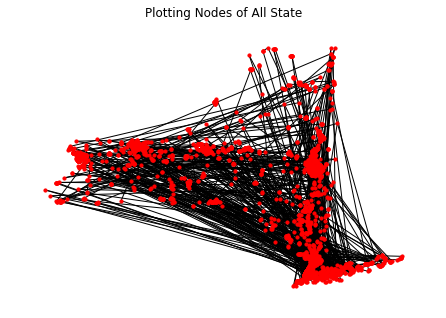

In [28]:
data = [(df, "red", "Plotting Nodes of All State"),]

for df, color, title in data:
    create_and_draw_graph(df, color, title)

plt.savefig("./graph_state_general.png", dpi=300)
plt.show()

In [52]:
df.shape

(17, 17)

In [30]:
tesla_df = df[df['EV_Network'] =="Tesla"]
evc_df = df[df['EV_Network'] =="EV Connect"]
l_df = df[df['EV_Network'] =="LIVINGSTON"]

In [31]:
tesla_df = tesla_df.sort_values(by=["City",'Latitude', 'Longitude'])
evc_df = evc_df.sort_values(by=["City",'Latitude', 'Longitude'])
l_df = l_df.sort_values(by=["City",'Latitude', 'Longitude'])

In [32]:
tesla_df["Next Latitude"] = tesla_df["Latitude"].shift(-1)
tesla_df["Next Longitude"] = tesla_df["Longitude"].shift(-1)
evc_df["Next Latitude"] = evc_df["Latitude"].shift(-1)
evc_df["Next Longitude"] = evc_df["Longitude"].shift(-1)
l_df["Next Latitude"] = l_df["Latitude"].shift(-1)
l_df["Next Longitude"] = l_df["Longitude"].shift(-1)

In [33]:
tesla_df =tesla_df.reset_index(drop=True)
evc_df =evc_df.reset_index(drop=True)
l_df =l_df.reset_index(drop=True)

In [34]:
tesla_df["Distance"]  = tesla_df.apply(getDistances, axis = 1)
tesla_df["Duration"]  = tesla_df.apply(getDuration, axis = 1)
evc_df["Distance"]  = evc_df.apply(getDistances, axis = 1)
evc_df["Duration"]  = evc_df.apply(getDuration, axis = 1)
l_df["Distance"]  = l_df.apply(getDistances, axis = 1)
l_df["Duration"]  = l_df.apply(getDuration, axis = 1)

Media di betweenness centrality per Tesla: [0.0]
Media di closeness centrality per Tesla: [0.16474243912816558]

Media di betweenness centrality per Livingston: [0.0]
Media di closeness centrality per Livingston: [0.19715335512309137]

Media di betweenness centrality per EV Connect: [0.0]
Media di closeness centrality per EV Connect: [0.18162180205987224]



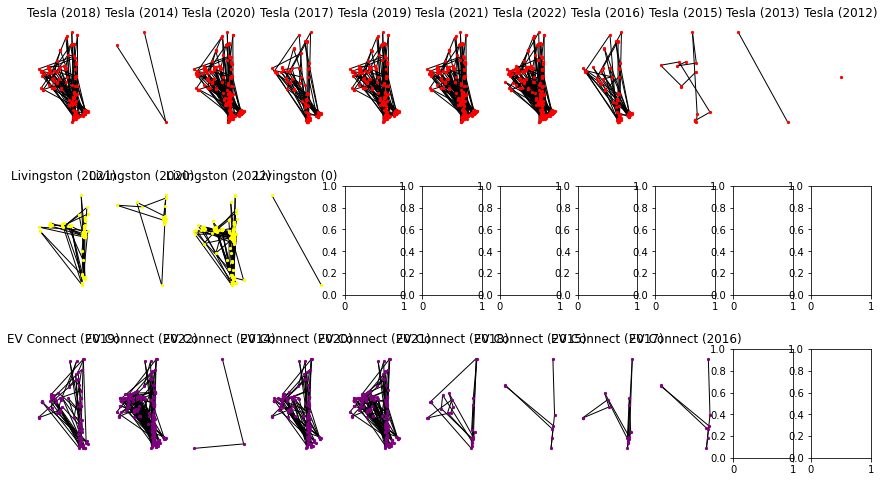

In [35]:
fig, axs = plt.subplots(3, tesla_df["Year"].nunique(), figsize=(15, 8))
data = [(tesla_df, "red", "Tesla"), (l_df, "yellow", "Livingston"), (evc_df, "purple", "EV Connect")]
betweenness_centralities = []
closeness_centralities = []

for i, (df, color, title) in enumerate(data):
    years = df["Year"].unique()
    for j, year in enumerate(years):
        G = nx.Graph()
        year=int(year)
        year_df = df[df["Year"].astype(int) <= year].reset_index(drop=True)
        for k in range(year_df.shape[0]):
            pos = (year_df.iloc[k]["Longitude"], year_df.iloc[k]["Latitude"])
            G.add_node(year_df.iloc[k]["ID"], pos=pos)
            if k > 0:
                G.add_edge(year_df.iloc[k-1]["ID"], year_df.iloc[k]["ID"])
        nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=False, node_size=5, node_color=color, ax=axs[i, j])
        axs[i, j].set_title("{} ({})".format(title, year))
#calcolo le misure di centralità
        betweenness = nx.betweenness_centrality(G)
        closeness = nx.closeness_centrality(G)
        
#print(betweenness)
        betweenness_centralities.append(list(betweenness.values()))
        closeness_centralities.append(list(closeness.values()))

#calcolo la media di betweenness e closeness per ogni dataframe
    avg_betweenness = [sum(x)/len(betweenness_centralities) for x in zip(*betweenness_centralities)]
    avg_closeness = [sum(x)/len(closeness_centralities) for x in zip(*closeness_centralities)]

    print("Media di betweenness centrality per {}: {}".format(title, avg_betweenness))
    print("Media di closeness centrality per {}: {}\n".format(title, avg_closeness))

# plt.tight_layout()
fig.subplots_adjust(wspace=0.3,hspace=0.5)
plt.savefig("./Graph_State_Years.png", dpi=600)
plt.show()

Il grafo risultante per l'intero stato si presenta molto confuso e poco significativo. L'unica informazione che si può ottenere è la maggiore concentrazione nelle aree urbane a densità maggiore, come si poteva facilmente prevedere: ad esempio le città di New York e Buffalo

L'analisi ora si sposta sulla sola città di New York

In [50]:
lista = ['New York',"Bronx","Brooklyn","Queens","Staten Island",
         "Manhattan","Borough Park","Washington Heights","New York City",
        "Astoria","Jamaica","JAMAICA","Jackson Heights",]
esclusione = ["Geneva on the Lake Resort", "ABELENORTHSIDE STATION 1","Buy Low Flooring / Queen of Harts Pizza"]
NYC_df = df.query("City in @lista")
NYC_df = NYC_df.query("City not in @esclusione")
NYC_df.index.names = ['Index']
NYC_df = NYC_df.fillna(value=0)
NYC_df =NYC_df.reset_index(drop=True)

In [51]:
NYC_df.shape

(17, 17)

In [38]:
NYC_df["Next Latitude"],NYC_df["Next Longitude"] = "",""
NYC_df["Next Latitude"] = NYC_df["Latitude"].shift(-1)
NYC_df["Next Longitude"] = NYC_df["Longitude"].shift(-1)
NYC_df

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Year,Distance,Duration,Next Latitude,Next Longitude
0,Jerome 190th Street Municipal Parking,2478 Jerome Avenue,Bronx,NY,0.0,5.0,0.0,EV Connect,40.863340,-73.900066,94830,J1772,2015,7.5408,10.611667,40.869205,-73.831633
1,Baychester Retail III LLC,500 Baychester Ave,Bronx,NY,0.0,3.0,0.0,EV Connect,40.869205,-73.831633,205822,J1772,2022,43.0875,43.270000,40.621698,-74.025670
2,Bay Ridge Municipal Parking Garage,8501 5th Ave,Brooklyn,NY,0.0,5.0,0.0,EV Connect,40.621698,-74.025670,65288,J1772,2015,8.0678,12.483333,40.668552,-73.978690
3,New York Presbyterian Hospital,510 5th St,Brooklyn,NY,0.0,8.0,0.0,EV Connect,40.668552,-73.978690,230870,J1772,2022,3.8607,8.578333,40.693463,-73.988245
4,Brooklyn Renaissance Plaza,335 Adams St,Brooklyn,NY,0.0,6.0,0.0,EV Connect,40.693463,-73.988245,230783,J1772,2022,2.5522,5.821667,40.699256,-73.969305
5,BNY - Building 6,63 Flushing Ave,Brooklyn,NY,0.0,1.0,0.0,EV Connect,40.699256,-73.969305,230787,J1772,2022,1.0164,2.915000,40.705481,-73.972208
6,BNY - Building 292,63 Flushing Ave,Brooklyn,NY,0.0,2.0,0.0,EV Connect,40.705481,-73.972208,230788,J1772,2022,602.2635,474.963333,40.729495,-73.988375
7,LaSalle Parking LLS Shumai LLC (220 E 9th St.),220 E 9th St,Manhattan,NY,0.0,3.0,0.0,EV Connect,40.729495,-73.988375,166333,J1772,2020,1.4976,3.396667,40.736763,-73.979743
8,Bonneville 329 E 22nd St.,"329 E 22nd St,",Manhattan,NY,0.0,4.0,0.0,EV Connect,40.736763,-73.979743,230843,J1772,2022,6.6910,10.811667,40.777932,-73.957152
9,GMC 127 East 83rd,127 E 83rd st,Manhattan,NY,0.0,4.0,0.0,EV Connect,40.777932,-73.957152,230846,J1772,2022,407.2318,310.885000,40.719319,-73.988197


In [39]:
NYC_df["Distance"]  = NYC_df.apply(getDistances, axis = 1)
NYC_df["Duration"]  = NYC_df.apply(getDuration, axis = 1)

Impongo, per sicurezza, che la distanza e la durata di viaggio non siano superiori a 100km e 100 minuti per evitare outliers.

In [40]:
NYC_df = NYC_df.loc[NYC_df['Distance'] < 100]
NYC_df = NYC_df.loc[NYC_df['Duration'] < 100]
NYC_df = NYC_df.loc[NYC_df['Distance'] != 0]
NYC_df = NYC_df.loc[NYC_df['Duration'] != 0]
NYC_df =NYC_df.reset_index(drop=True)

In [49]:
NYC_df.shape

(17, 17)

In [42]:
quantiles = NYC_df["Distance"].quantile([0.25, 0.75])
media = NYC_df["Distance"].mean()
minimum = NYC_df["Distance"].min()
maximum = NYC_df["Distance"].max()


print("\nDistance")
print("\nQuantili a 0.25 e 0.75:")
print(quantiles)
print("Media :" + str(media))
print("Minimo :"+str(minimum))
print("Massimo :"+ str(maximum))


quantiles_d= NYC_df["Duration"].quantile([0.25, 0.75])
media_d = NYC_df["Duration"].mean()
print("\nDuration")
print("\nQuantili a 0.25 e 0.75:")
minimum_d = NYC_df["Duration"].min()
maximum_d = NYC_df["Duration"].max()
print(quantiles_d)
print("Media :" +str(media_d))
print("Minimo :"+str(minimum_d))
print("Massimo :"+ str(maximum_d))


Distance

Quantili a 0.25 e 0.75:
0.25    3.3692
0.75    9.3500
Name: Distance, dtype: float64
Media :8.717541176470588
Minimo :0.6402
Massimo :43.0875

Duration

Quantili a 0.25 e 0.75:
0.25     5.821667
0.75    12.851667
Name: Duration, dtype: float64
Media :11.937745098039215
Minimo :1.4533333333333334
Massimo :43.269999999999996


Le distanze tra le colonnine vanno dai circa 0.5km a sopra i 47km, con una media attorno ai 3km.
Per quanto riguarda il tempo tra una colonnina e l'altro si passa da poco più di 1 minuto e mezzo agli oltre 6, secondo i quantili, con una media di poco inferiore ai 5 minuti tra una e l'altra. Qui stiamo prendendo in esame tutte le stazioni, non solo quelle relative ai network Tesla, Livingston ed EV Connect.

In [43]:
NYC_df

,Station Name,Street Address,City,State,EV Level1 EVSE Num,EV Level2 EVSE Num,EV DC Fast Count,EV_Network,Latitude,Longitude,ID,EV Connector Types,Year,Distance,Duration,Next Latitude,Next Longitude
0,Jerome 190th Street Municipal Parking,2478 Jerome Avenue,Bronx,NY,0.0,5.0,0.0,EV Connect,40.863340,-73.900066,94830,J1772,2015,7.5408,10.611667,40.869205,-73.831633
1,Baychester Retail III LLC,500 Baychester Ave,Bronx,NY,0.0,3.0,0.0,EV Connect,40.869205,-73.831633,205822,J1772,2022,43.0875,43.270000,40.621698,-74.025670
2,Bay Ridge Municipal Parking Garage,8501 5th Ave,Brooklyn,NY,0.0,5.0,0.0,EV Connect,40.621698,-74.025670,65288,J1772,2015,8.0678,12.483333,40.668552,-73.978690
3,New York Presbyterian Hospital,510 5th St,Brooklyn,NY,0.0,8.0,0.0,EV Connect,40.668552,-73.978690,230870,J1772,2022,3.8607,8.578333,40.693463,-73.988245
4,Brooklyn Renaissance Plaza,335 Adams St,Brooklyn,NY,0.0,6.0,0.0,EV Connect,40.693463,-73.988245,230783,J1772,2022,2.5522,5.821667,40.699256,-73.969305
5,BNY - Building 6,63 Flushing Ave,Brooklyn,NY,0.0,1.0,0.0,EV Connect,40.699256,-73.969305,230787,J1772,2022,1.0164,2.915000,40.705481,-73.972208
6,BNY - Building 292,63 Flushing Ave,Brooklyn,NY,0.0,2.0,0.0,EV Connect,40.705481,-73.972208,230788,J1772,2022,6.3828,12.851667,40.729495,-73.988375
7,LaSalle Parking LLS Shumai LLC (220 E 9th St.),220 E 9th St,Manhattan,NY,0.0,3.0,0.0,EV Connect,40.729495,-73.988375,166333,J1772,2020,1.4976,3.396667,40.736763,-73.979743
8,Bonneville 329 E 22nd St.,"329 E 22nd St,",Manhattan,NY,0.0,4.0,0.0,EV Connect,40.736763,-73.979743,230843,J1772,2022,6.6910,10.811667,40.777932,-73.957152
9,GMC 127 East 83rd,127 E 83rd st,Manhattan,NY,0.0,4.0,0.0,EV Connect,40.777932,-73.957152,230846,J1772,2022,9.3500,14.268333,40.719319,-73.988197


La media delle distanze nella 

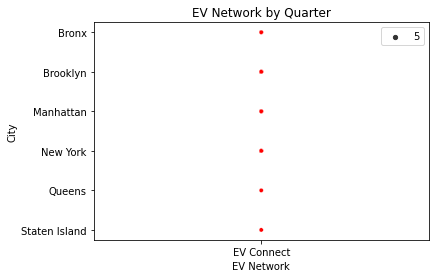

In [44]:
sns.scatterplot(x='EV_Network', y='City', data=NYC_df, size=5, color='red')
plt.title("EV Network by Quarter")
plt.xlabel("EV Network")
plt.ylabel("City")
plt.show()

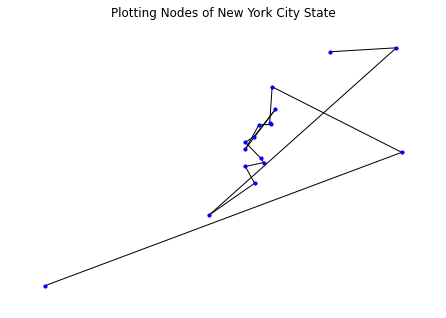

In [45]:
data = [(NYC_df, "blue", "Plotting Nodes of New York City State"),]

for df, color, title in data:
    create_and_draw_graph(df, color, title)

plt.savefig("./graph_city_general.png", dpi=300)
plt.show()

In [46]:
location = NYC_df[["Latitude", "Longitude", "Station Name","EV_Network","ID","City"]]
print(location)

     Latitude  Longitude                                       Station Name  \
0   40.863340 -73.900066              Jerome 190th Street Municipal Parking   
1   40.869205 -73.831633                          Baychester Retail III LLC   
2   40.621698 -74.025670                 Bay Ridge Municipal Parking Garage   
3   40.668552 -73.978690                     New York Presbyterian Hospital   
4   40.693463 -73.988245                         Brooklyn Renaissance Plaza   
5   40.699256 -73.969305                                   BNY - Building 6   
6   40.705481 -73.972208                                 BNY - Building 292   
7   40.729495 -73.988375     LaSalle Parking LLS Shumai LLC (220 E 9th St.)   
8   40.736763 -73.979743                          Bonneville 329 E 22nd St.   
9   40.777932 -73.957152                                  GMC 127 East 83rd   
10  40.719319 -73.988197        Delancey and Essex Municipal Parking Garage   
11  40.755190 -73.974142                            

In [47]:

# Calculate the center of the map based on the mean of Latitude and Longitude values
mean_latitude = location['Latitude'].mean()
mean_longitude = location['Longitude'].mean()
map = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=10, control_scale=True)

location.apply(lambda x: folium.Marker([x["Latitude"], x["Longitude"]], popup=x["EV_Network"]).add_to(map), axis=1)
map
